**Part 1: Analyze and Explore the Climate Data**

In this section, you’ll use Python and SQLAlchemy to do a basic climate analysis and data exploration of your climate database. Specifically, you’ll use SQLAlchemy ORM queries, Pandas, and Matplotlib. To do so, complete the following steps:

1) Note that you’ll use the provided files (climate_starter.ipynb and hawaii.sqlite) to complete your climate analysis and data exploration.
2) Use the SQLAlchemy create_engine() function to connect to your SQLite database.
3) Use the SQLAlchemy automap_base() function to reflect your tables into classes, and then save references to the classes named station and measurement.
4) Link Python to the database by creating a SQLAlchemy session.
    Remember to close your session at the end of your notebook.
5) Perform a precipitation analysis and then a station analysis by completing the steps in the following two subsections.

In [1]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import inspect
from sqlalchemy import func, Date, cast, Integer

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta


In [2]:
# Use the SQLAlchemy create_engine() function to connect to your SQLite database.

engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [3]:
# Use the SQLAlchemy automap_base() function to reflect your tables into classes, and then save references to the classes named station and measurement.

Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()


['station', 'measurement']

In [4]:
# saved references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

**Percipitation Analysis**

1) Find the most recent date in the dataset.
2) Using that date, get the previous 12

In [5]:
prcp_session = Session(engine)

most_recent_date = prcp_session.query(func.max(Measurement.date)).scalar()
print("Most recent date:", most_recent_date)

Most recent date: 2017-08-23


In [6]:
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)

results = (
    prcp_session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

date_prcp_df = pd.DataFrame(results, columns=['date', 'precipitation']).sort_values(by='date')
date_prcp_df.head()

,date,precipitation
0,2016-08-24,0.08
1006,2016-08-24,NaN
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15


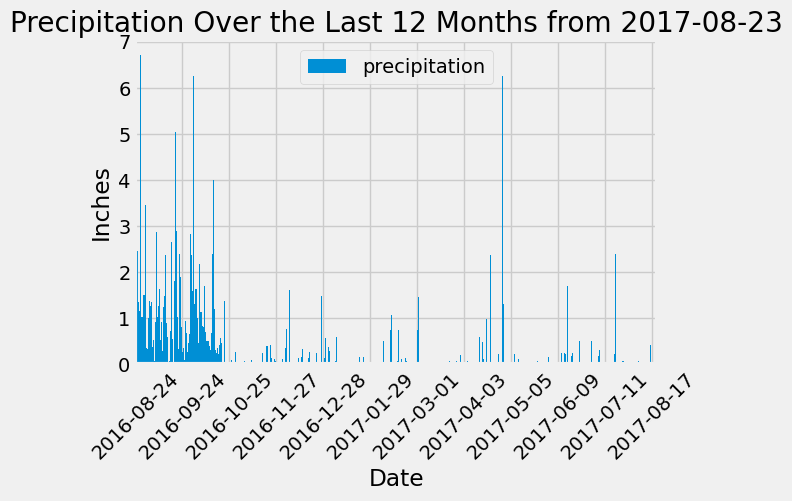

In [7]:
date_prcp_df.plot(x='date', y='precipitation', kind='bar', figsize=(6,4), legend=True)
plt.bar(date_prcp_df['date'], date_prcp_df['precipitation'], width=5.0)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))
plt.title("Precipitation Over the Last 12 Months from 2017-08-23")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=45)
plt.show()


In [8]:
summary_statistics = date_prcp_df.describe()
summary_statistics

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [9]:
# close notebook
prcp_session.close()

Station Analysis

In [10]:
# how many stations are in the data set?
station_session = Session(engine)

station_count = station_session.query(func.count(Station.station)).scalar()
print("Number of Stations:", station_count)

Number of Stations: 9


In [11]:
# query that lists the stations and observation counts in descending order
# return the most activate station <-- return the func.max(Measurement.)

station_obs = station_session.query(
    Measurement.station,
    func.count(Measurement.station).label('observation_count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

station_obs_df = pd.DataFrame(station_obs, columns=['Stations', 'Observation Count'])

most_active_station = station_obs_df.iloc[0]
print(f"The most active station is {most_active_station['Stations']} with {most_active_station['Observation Count']} observations.")

station_obs_df

The most active station is USC00519281 with 2772 observations.


,Stations,Observation Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [12]:
temp_stats = station_session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == 'USC00519281').all()

# Extract the results
min_temp, max_temp, avg_temp = temp_stats[0]

print('Temperature statistics for the most station USC00519281')
print(f"Min Temperature: {min_temp}")
print(f"Max Temperature: {max_temp}")
print(f"Avg Temperature: {avg_temp}")


Temperature statistics for the most station USC00519281
Min Temperature: 54.0
Max Temperature: 85.0
Avg Temperature: 71.66378066378067


In [13]:
baseline_tobs_date = station_session.query(func.max(Measurement.date)).filter(Measurement.station == 'USC00519281').scalar()
print("Most recent date:", baseline_tobs_date)

baseline_tobs_date = datetime.strptime(baseline_tobs_date, '%Y-%m-%d')
one_year_ago_tobs = baseline_tobs_date - timedelta(days=365)


Most recent date: 2017-08-18


In [14]:
tobs_results = (
    station_session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.date >= one_year_ago_tobs)
    .filter(Measurement.station == 'USC00519281')
    .all()
)

tobs_df = pd.DataFrame(tobs_results, columns=['date', 'tobs'])
tobs_df

,date,tobs
0,2016-08-19,79.0
1,2016-08-20,81.0
2,2016-08-21,79.0
3,2016-08-22,78.0
4,2016-08-23,77.0
...,...,...
351,2017-08-14,77.0
352,2017-08-15,77.0
353,2017-08-16,76.0
354,2017-08-17,76.0


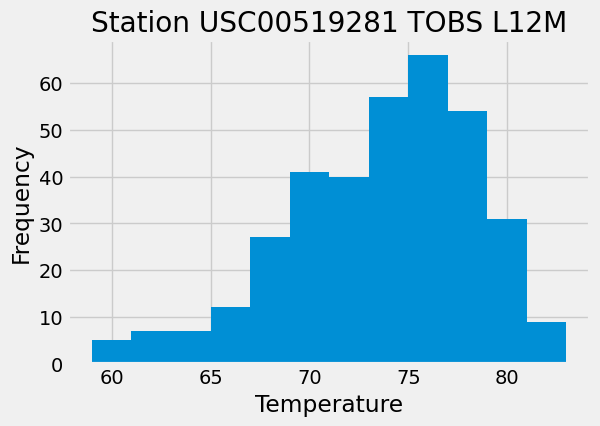

In [15]:
tobs_df['tobs'].hist(bins=12, figsize=(6,4))
plt.title("Station USC00519281 TOBS L12M")
plt.xlabel("Temperature")
plt.ylabel("Frequency")

# Show the plot
plt.show()

In [16]:
station_session.close()

API SQLite Connection & Landing Page